# Complete Exploratory Data Analysis

In [53]:
# load libraries
from contextlib import contextmanager
from datetime import datetime
from pathlib import Path
import os
from typing import Optional

import matplotlib.pyplot as plt
import polars as pl
import psutil
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date

# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Set display width to ensure it doesn't wrap awkwardly
pd.set_option('display.width', 1000)

In [2]:
# -- Congiguration --
# Robustly determine the project root directory
try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # This executes if running in a Jupyter Notebook
    SCRIPT_DIR = Path.cwd()

PROJECT_ROOT = SCRIPT_DIR.parent # Or SCRIPT_DIR if your notebook is in the root
DATA_DIR = PROJECT_ROOT / "data"
PLOTS_DIR = SCRIPT_DIR / "plots"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

# Create plots directory if it doesn't exist
PLOTS_DIR.mkdir(exist_ok=True)

print(f"Project Root identified as: {PROJECT_ROOT}")

Project Root identified as: /Users/kshitijgurung/Desktop/OMSA GT/practicum/bitcoin-analytics-capstone


In [3]:
# --- Memory Tracking Utilities ---
def get_memory_usage_mb() -> float:
    """
    Get current memory usage of the process in MB.

    Returns:
        Memory usage in megabytes
    """
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024


def format_memory(mb: float) -> str:
    """
    Format memory value in MB to human-readable string.

    Args:
        mb: Memory value in megabytes

    Returns:
        Formatted string (e.g., "123.45 MB" or "1.23 GB")
    """
    if mb < 1024:
        return f"{mb:.2f} MB"
    else:
        return f"{mb / 1024:.2f} GB"


@contextmanager
def track_memory(operation_name: str):
    """
    Context manager to track memory usage before and after an operation.

    Args:
        operation_name: Name of the operation being tracked

    Yields:
        None
    """
    memory_before = get_memory_usage_mb()
    print(f"[Memory] Before {operation_name}: {format_memory(memory_before)}")

    try:
        yield
    finally:
        memory_after = get_memory_usage_mb()
        memory_delta = memory_after - memory_before
        print(
            f"[Memory] After {operation_name}: {format_memory(memory_after)} "
            f"(Δ {format_memory(memory_delta)})"
        )


# --- Data Loading Functions ---


def load_bitcoin_data(filepath: Path) -> Optional[pl.DataFrame]:
    """
    Load Bitcoin data from CSV using Polars lazy scan.

    Args:
        filepath: Path to the Coin Metrics CSV file

    Returns:
        Polars DataFrame with parsed datetime column, or None if loading fails
    """
    print(f"Loading Bitcoin data from {filepath}...")
    try:
        with track_memory("loading Bitcoin data"):
            df = (
                pl.scan_csv(filepath, infer_schema_length=10000)
                .with_columns(pl.col("time").str.to_datetime())
                .collect()
            )
        print(f"Successfully loaded {len(df)} rows.")
        return df
    except Exception as e:
        print(f"Error loading Bitcoin data: {e}")
        return None


def load_polymarket_data(datadir: Path) -> Optional[dict[str, pl.DataFrame]]:
    """
    Load Polymarket data from parquet files using Polars lazy scan.

    Args:
        datadir: Directory containing Polymarket parquet files

    Returns:
        Dictionary mapping data type names to Polars DataFrames, or None if loading fails
    """
    print(f"Loading Polymarket data from {datadir}...")
    markets_path = datadir / "finance_politics_markets.parquet"
    odds_path = datadir / "finance_politics_odds_history.parquet"
    summary_path = datadir / "finance_politics_summary.parquet"

    data: dict[str, pl.DataFrame] = {}

    try:
        with track_memory("loading Polymarket data"):
            if markets_path.exists():
                # Load with lazy scan, then collect and handle datetime columns
                markets_df = pl.scan_parquet(markets_path).collect()
                
                # Convert datetime columns only if they exist and are strings
                # (parquet files may already have proper datetime types)
                datetime_cols = []
                for col_name in ["created_at", "end_date"]:
                    if col_name in markets_df.columns:
                        col_dtype = markets_df[col_name].dtype
                        if col_dtype == pl.String or col_dtype == pl.Utf8:
                            datetime_cols.append(pl.col(col_name).str.to_datetime())
                
                if datetime_cols:
                    markets_df = markets_df.with_columns(datetime_cols)
                
                # Fix timestamp corruption
                for col in markets_df.columns:
                    if any(x in col.lower() for x in ["timestamp", "trade", "created_at", "end_date"]):
                        if markets_df[col].dtype == pl.Datetime or markets_df[col].dtype == pl.Date:
                            if not markets_df[col].is_empty() and markets_df[col].max() < datetime(2020, 1, 1):
                                markets_df = markets_df.with_columns((pl.col(col).cast(pl.Int64) * 1000).cast(pl.Datetime))
                                
                        # Enforce 2020+ constraint (replace placeholders/zeros with null)
                        if markets_df[col].dtype == pl.Datetime or markets_df[col].dtype == pl.Date:
                             markets_df = markets_df.with_columns(
                                 pl.when(pl.col(col) < datetime(2020, 1, 1))
                                 .then(None)
                                 .otherwise(pl.col(col))
                                 .alias(col)
                             )
                
                data["markets"] = markets_df
                print(f"Loaded {len(markets_df)} markets.")

            if odds_path.exists():
                odds_df = pl.scan_parquet(odds_path).collect()
                
                # Fix timestamp corruption
                for col in odds_df.columns:
                    if any(x in col.lower() for x in ["timestamp", "trade", "created_at", "end_date"]):
                        if odds_df[col].dtype == pl.Datetime or odds_df[col].dtype == pl.Date:
                            if not odds_df[col].is_empty() and odds_df[col].max() < datetime(2020, 1, 1):
                                odds_df = odds_df.with_columns((pl.col(col).cast(pl.Int64) * 1000).cast(pl.Datetime))
                                
                        # Enforce 2020+ constraint (replace placeholders/zeros with null)
                        if odds_df[col].dtype == pl.Datetime or odds_df[col].dtype == pl.Date:
                             odds_df = odds_df.with_columns(
                                 pl.when(pl.col(col) < datetime(2020, 1, 1))
                                 .then(None)
                                 .otherwise(pl.col(col))
                                 .alias(col)
                             )
                            
                data["odds"] = odds_df
                print(f"Loaded {len(odds_df)} odds history records.")

            if summary_path.exists():
                summary_df = pl.scan_parquet(summary_path).collect()
                
                # Fix timestamp corruption
                for col in summary_df.columns:
                    if any(x in col.lower() for x in ["timestamp", "trade", "created_at", "end_date"]):
                        if summary_df[col].dtype == pl.Datetime or summary_df[col].dtype == pl.Date:
                            if not summary_df[col].is_empty() and summary_df[col].max() < datetime(2020, 1, 1):
                                summary_df = summary_df.with_columns((pl.col(col).cast(pl.Int64) * 1000).cast(pl.Datetime))
                                
                        # Enforce 2020+ constraint (replace placeholders/zeros with null)
                        if summary_df[col].dtype == pl.Datetime or summary_df[col].dtype == pl.Date:
                             summary_df = summary_df.with_columns(
                                 pl.when(pl.col(col) < datetime(2020, 1, 1))
                                 .then(None)
                                 .otherwise(pl.col(col))
                                 .alias(col)
                             )
                            
                data["summary"] = summary_df
                print(f"Loaded {len(summary_df)} summary records.")

        return data if data else None
    except Exception as e:
        print(f"Error loading Polymarket data: {e}")
        return None



# Coinmetrics EDA

In [63]:
# # Load data using lazy evaluation
# btc_df = load_bitcoin_data(COINMETRICS_PATH)
# # configure data filter
# start_date = date(2018,1,1)
# end_date = date(2025,12,31)
# c_df = btc_df.filter(pl.col("time") >= start_date)
# c_df.shape

In [65]:
# Load data
coin_df = pd.read_csv('../data/Coin Metrics/coinmetrics_btc.csv')
coin_df["time"] = pd.to_datetime(coin_df["time"])
print(coin_df.shape)
coin_df.head()

(6221, 32)


,time,AdrActCnt,AdrBalCnt,AssetCompletionTime,AssetEODCompletionTime,BlkCnt,CapMVRVCur,CapMrktCurUSD,CapMrktEstUSD,FeeTotNtv,FlowInExNtv,FlowInExUSD,FlowOutExNtv,FlowOutExUSD,HashRate,IssTotNtv,IssTotUSD,PriceBTC,PriceUSD,ROI1yr,ROI30d,ReferenceRate,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d
0,2009-01-03,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1,2009-01-04,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
2,2009-01-05,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
3,2009-01-06,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
4,2009-01-07,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN


In [55]:
# high level preivew of all fields
stats_df = coin_df.describe(include='all')
print(stats_df)
stats_df = coin_df.describe(include='all')
print(stats_df)

                      time     AdrActCnt     AdrBalCnt  AssetCompletionTime  AssetEODCompletionTime       BlkCnt   CapMVRVCur  CapMrktCurUSD  CapMrktEstUSD    FeeTotNtv    FlowInExNtv   FlowInExUSD   FlowOutExNtv  FlowOutExUSD      HashRate     IssTotNtv     IssTotUSD  PriceBTC       PriceUSD        ROI1yr       ROI30d  ReferenceRate  ReferenceRateETH  ReferenceRateEUR  ReferenceRateUSD       SplyCur     SplyExNtv     SplyExUSD  SplyExpFut10yr          TxCnt      TxTfrCnt  volume_reported_spot_usd_1d
count                 6221  6.220000e+03  6.220000e+03         6.220000e+03            6.220000e+03  6220.000000  5659.000000   5.659000e+03   2.398000e+03  6220.000000    6220.000000  5.659000e+03    6220.000000  5.659000e+03  6.214000e+03   6214.000000  5.659000e+03    6220.0    5659.000000   5294.000000  5629.000000       7.000000          7.000000          7.000000          7.000000  6.220000e+03  6.220000e+03  5.659000e+03    6.214000e+03    6220.000000  6.220000e+03                 5

In [ ]:
# nulls
print(coin_df.isnull().sum())

time                              0
AdrActCnt                         1
AdrBalCnt                         1
AssetCompletionTime               1
AssetEODCompletionTime            1
BlkCnt                            1
CapMVRVCur                      562
CapMrktCurUSD                   562
CapMrktEstUSD                  3823
FeeTotNtv                         1
FlowInExNtv                       1
FlowInExUSD                     562
FlowOutExNtv                      1
FlowOutExUSD                    562
HashRate                          7
IssTotNtv                         7
IssTotUSD                       562
PriceBTC                          1
PriceUSD                        562
ROI1yr                          927
ROI30d                          592
ReferenceRate                  6214
ReferenceRateETH               6214
ReferenceRateEUR               6214
ReferenceRateUSD               6214
SplyCur                           1
SplyExNtv                         1
SplyExUSD                   

# Visualizations

### Build correlation heat map

Top 10 Metrics Positively Correlated with Price:
PriceUSD                  1.000000
CapMrktCurUSD             0.999698
CapMrktEstUSD             0.999646
SplyExUSD                 0.973293
HashRate                  0.931277
AssetCompletionTime       0.893526
AssetEODCompletionTime    0.893526
IssTotUSD                 0.889424
FlowInExUSD               0.885303
FlowOutExUSD              0.868940
SplyExNtv                 0.822008
Name: PriceUSD, dtype: float64

Top 5 Metrics Negatively Correlated with Price:
ROI30d      -0.107268
ROI1yr      -0.149928
BlkCnt      -0.193192
IssTotNtv   -0.545371
PriceBTC          NaN
Name: PriceUSD, dtype: float64


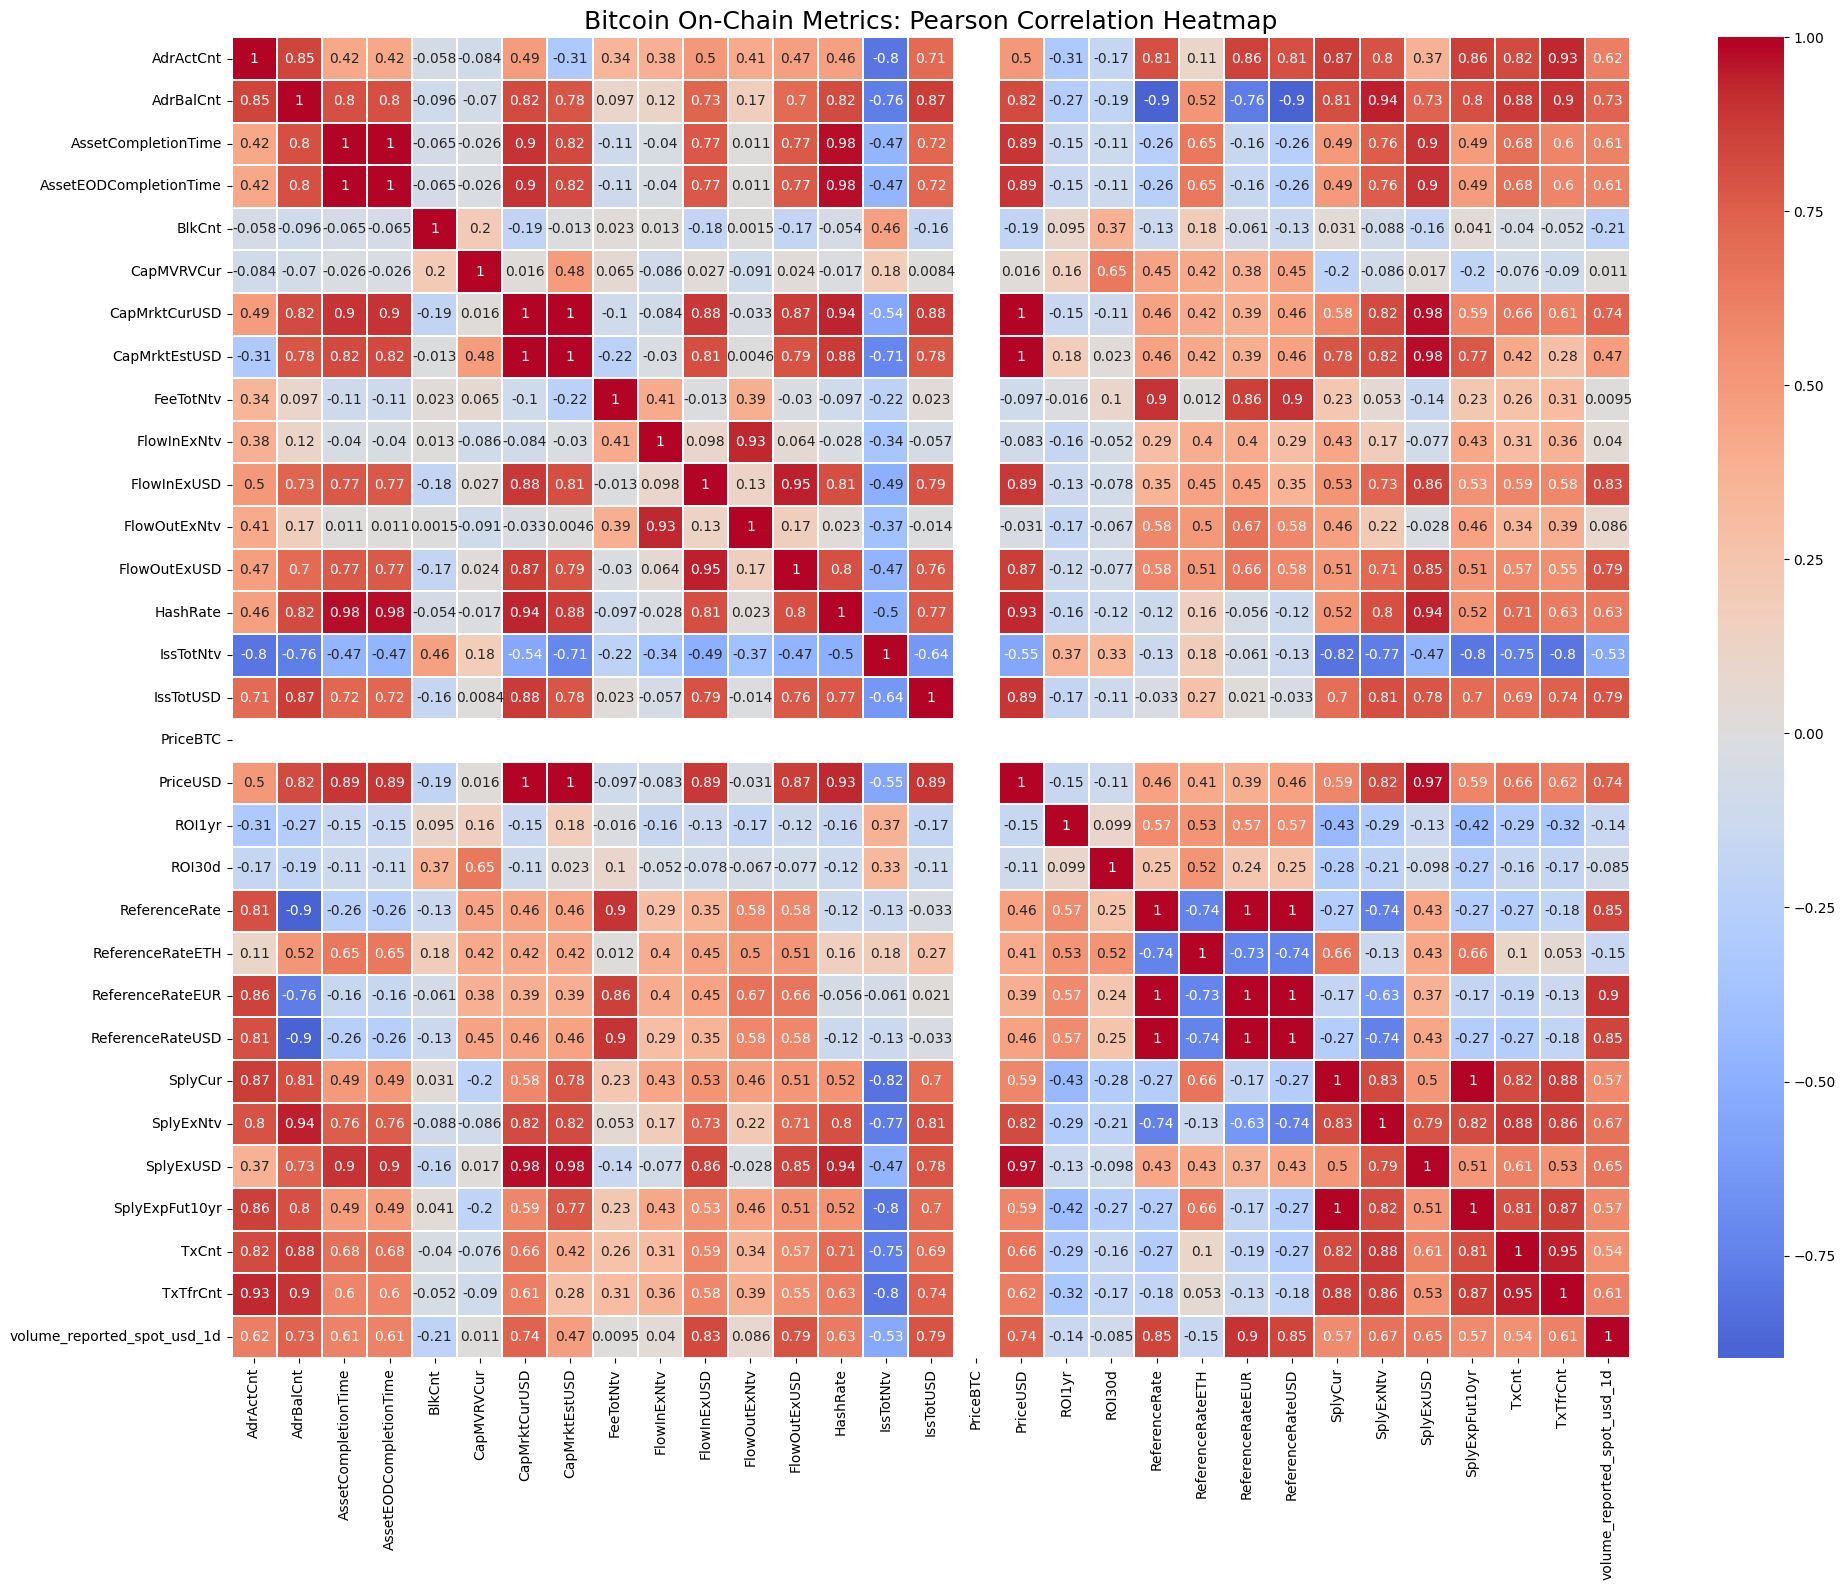

In [ ]:
# Correlation Matrix
corr_matrix = coin_df.corr(numeric_only=True)

# Save the matrix to a CSV for detailed inspection
corr_matrix.to_csv("../eda/plots/btc_correlation_results.csv")

# Plot Correlation Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix, 
    annot=True,         
    cmap='coolwarm',     
    center=0, 
    linewidths=0.1
)

plt.title('Bitcoin Coin Metrics: Pearson Correlation Heatmap', fontsize=18)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

# PriceUSD Correlations
price_correlations = corr_matrix['PriceUSD'].sort_values(ascending=False)
print("Top 10 Metrics Positively Correlated with Price:")
print(price_correlations.head(11))

print("\nTop 5 Metrics Negatively Correlated with Price:")
print(price_correlations.tail(5))

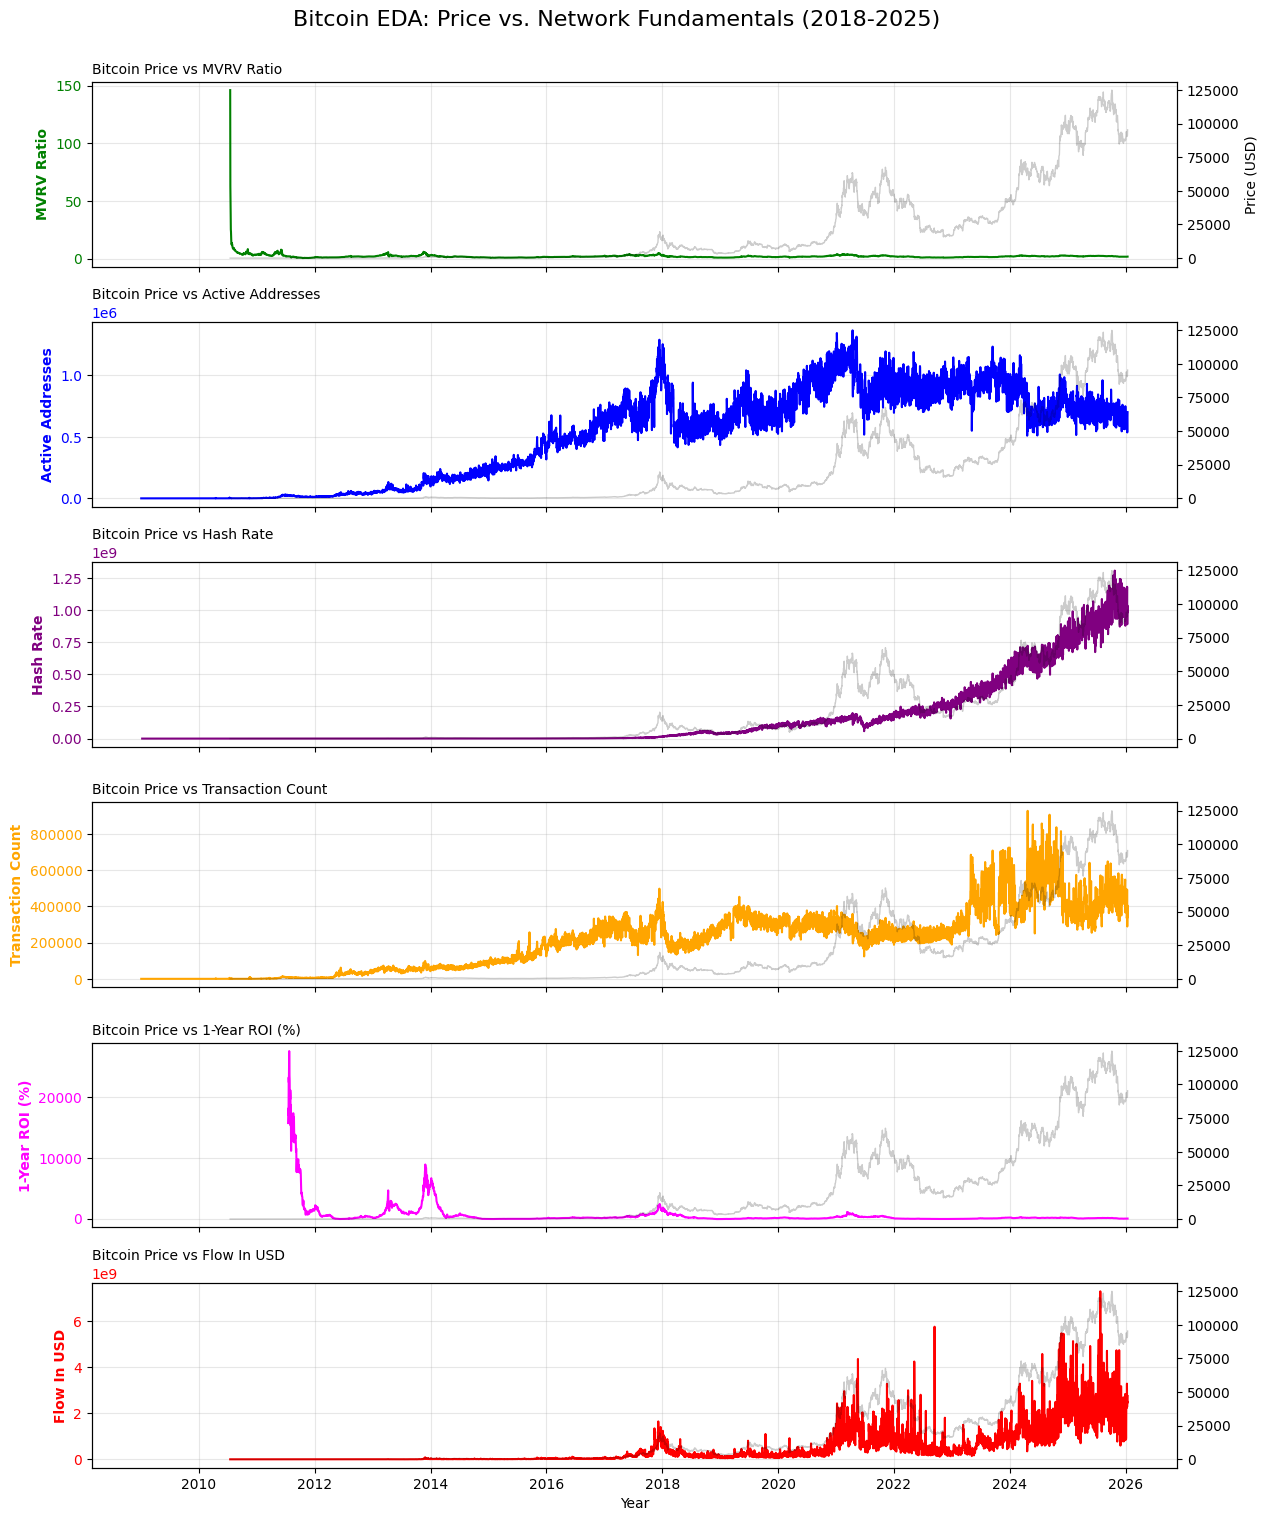

In [62]:
# Setup the Figure with 5 Subplots
fig, axes = plt.subplots(6, 1, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.3)

# Define our 5 Top EDA metrics and their colors
metrics = [
    ('CapMVRVCur', 'green', 'MVRV Ratio'),
    ('AdrActCnt', 'blue', 'Active Addresses'),
    ('HashRate', 'purple', 'Hash Rate'),
    ('TxCnt', 'orange', 'Transaction Count'),
    ('ROI1yr', 'magenta', '1-Year ROI (%)'),
    ('FlowInExUSD', 'red', 'Flow In USD'),

]

# Loop through metrics to create the stack
for i, (col_name, color, label) in enumerate(metrics):
    ax = axes[i]
    
    # Plot the specific Metric
    ax.plot(coin_df['time'], coin_df[col_name], color=color, linewidth=1.5, label=label)
    ax.set_ylabel(label, color=color, fontweight='bold')
    ax.tick_params(axis='y', labelcolor=color)
    ax.grid(True, alpha=0.3)
    
    # Overlay Price on a secondary axis for EVERY subplot
    ax_price = ax.twinx()
    ax_price.plot(coin_df['time'], coin_df['PriceUSD'], color='black', alpha=0.2, linewidth=1)
    if i == 0:
        ax_price.set_ylabel('Price (USD)', color='black')
    
    ax.set_title(f'Bitcoin Price vs {label}', loc='left', fontsize=10)

# Final Formatting
axes[-1].set_xlabel('Year')
plt.suptitle('Bitcoin EDA: Price vs. Network Fundamentals (2018-2025)', fontsize=16, y=0.92)
plt.show()

We see that there is a massive divergence in 2024 to 2025: while the price increased to $120k, several fundamental metrics (such as Active Addresses and Transaction Counts) actually leveled off or declined.

Unlike the price, the Hash Rate is a near-constant upward line. Even during the 2022 bear market, the Hash Rate continued to climb, which suggests that miners are consistently investing in long-term security of network.

# Polymarket

In [5]:
# Load data using lazy evaluation
poly_data = load_polymarket_data(POLYMARKET_DIR)

Loading Polymarket data from /Users/kshitijgurung/Desktop/OMSA GT/practicum/bitcoin-analytics-capstone/data/Polymarket...
[Memory] Before loading Polymarket data: 66.62 MB
Loaded 78321 markets.
Loaded 2143181 odds history records.
Loaded 78321 summary records.
[Memory] After loading Polymarket data: 245.70 MB (Δ 179.08 MB)


In [42]:
markets_df = poly_data.get("markets")

In [ ]:
print(markets_df.columns)
markets_df.sort(by='volume', descending=True)[:10, :]